# Tiny but Mighty: Aspect-Based Classification with TinyBERT, Hugging Face Transformers, and PyTorch

## 🧠 Introduction

In this project, we address the task of **text classification** within the movie domain, using a dataset of reviews from IMDB. The main goal is to **predict the thematic aspect** (Story, Characters, or Cinematography) that each review focuses on.

To achieve this, we implement two main approaches:

1. A **simple neural network** with trainable embeddings from scratch, used as a baseline.
2. A **pretrained TinyBERT model**, partially fine-tuned to our specific task.

## 🎯 Objective

- Build a model capable of automatically classifying movie reviews by thematic aspect.
- Compare the performance of a simple neural model with a pretrained Transformer.
- Extract insights from text analysis, including most frequent words.
- Visualize model performance through graphs to gain a better understanding of the results.

## 🔧 Methodology and Workflow

1. **Data loading and cleaning**: Reading training and test datasets, basic exploratory analysis, and tokenization.
2. **Preprocessing**: Vocabulary construction, encoding, and padding.
3. **Baseline training**: Simple neural network with embedding layers.
4. **Model evaluation**: Classification metrics and confusion matrix.
5. **TinyBERT fine-tuning**: Freezing most layers and adjusting to our domain-specific task.
6. **Performance comparison**: Visual analysis and summary of both approaches.

This pipeline enables us to evaluate how both traditional and state-of-the-art NLP models perform on a practical classification task, giving us experience with both foundational and modern tools.

---

**Setup - Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
torch.manual_seed(42)

from transformers import logging
logging.set_verbosity_error() # we remove warnings

## Import and Inspect the Movie Reviews

Let's first import and inspect the datasets containing the movie reviews!

In this project, we'll be classifying different _aspects_ within movie reviews from IMDB (Internet Movie Database), which is a free online database containing data on movies, TV shows, and other types of media.

We've obtained the movie reviews from this [Hugging Face Dataset](https://huggingface.co/datasets/Lowerated/lm6-movies-reviews-aspects) that we've cleaned and pre-processed into the following csv files:
- `"imdb_movie_reviews_train.csv"` - contains movie reviews in the training dataset
- `"imdb_movie_reviews_test.csv"` - contains the movie reviews in the testing dataset

Here's a quick summary of the columns in the dataset:

- `review` - the text of the movie review
- `aspect` - the thematic aspect of the movie the review targets
- `aspect_encoded` an integer label encoding the `aspect` column

We can start by importing the CSV file to a pandas DataFrame named `train_reviews_df`.

Then we use the `.head()`  and `.info()`method to preview the first five rows and some basic statics about the dataset

In [2]:
train_reviews_df = pd.read_csv('imdb_movie_reviews_train.csv')
print(train_reviews_df.head())
display(train_reviews_df)

                                              review          aspect  \
0       Ibiza filming location looks very enchanting  Cinematography   
1  RANDOLPH SCOTT always played men you could loo...      Characters   
2  interesting and promising basic idea', 'some p...           Story   
3  the film could explore very powerful politics,...           Story   
4  The animation is nice, and the use of color ma...  Cinematography   

   aspect_encoded  
0               0  
1               1  
2               2  
3               2  
4               0  


,review,aspect,aspect_encoded
0,Ibiza filming location looks very enchanting,Cinematography,0
1,RANDOLPH SCOTT always played men you could loo...,Characters,1
2,"interesting and promising basic idea', 'some p...",Story,2
3,"the film could explore very powerful politics,...",Story,2
4,"The animation is nice, and the use of color ma...",Cinematography,0
...,...,...,...
364,"obviously shot on video tape', 'very poorly at...",Cinematography,0
365,"it is humorous how bad it is', ""i've seen porn...",Story,2
366,Everything that is seen or heard on the screen...,Cinematography,0
367,"the actors delivered up to standard', 'only on...",Characters,1


Next, use `.info()` to inspect the training dataset. Make sure the data types for each column make sense and if there are any missing values.

In [3]:
print(train_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          369 non-null    object
 1   aspect          369 non-null    object
 2   aspect_encoded  369 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.8+ KB
None


Let's explore the different aspect labels in the training dataset.

We can use the `.value_counts()` method on the `aspect` column to count the number of aspect labels.

After that, we do the same for the `aspect_encoded` column to verify that the number of aspect labels correspond equally.

In [4]:
print(train_reviews_df.aspect.value_counts())

print(train_reviews_df.aspect_encoded.value_counts())

aspect
Cinematography    125
Characters        123
Story             121
Name: count, dtype: int64
aspect_encoded
0    125
1    123
2    121
Name: count, dtype: int64


Here's a quick summary of each aspect:

- **Cinematography** focuses on the movie's visual elements like the locations, quality, lighting, and visual appeal
- **Characters** addresses the portrayal of characters and their development throughout the movie, which can focus on their acting, personality, depth, and relatability
- **Story** highlights the movie's themes, plots, originality, and quality of storytelling

Since each movie review is classified into one of the three aspects, we'll frame this task as a **multi-class** classification task. 

Let's save the number of aspects to the variable `n_aspects`, which we'll reference later when we build the neural network and BERT transformer using PyTorch.

In [5]:
n_aspects = train_reviews_df['aspect'].nunique()
print(n_aspects) # this value represents the number of classes for classification

3


#### Chek the Plot for Distribution of Aspects in Reviews

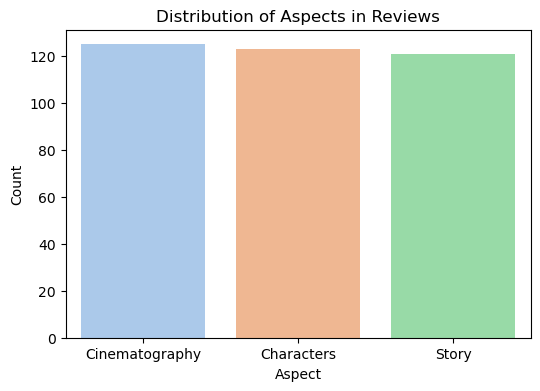

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(x='aspect', data=train_reviews_df, hue='aspect', palette='pastel', legend=False)
plt.title('Distribution of Aspects in Reviews')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.show()

Next, create the _training corpus_ by using the `.tolist()` function to convert the text sequence in each review and their corresponding aspect labels to the following lists:

- `train_texts` contains each movie review separated by commas
- `train_labels` contains each review aspect separated by commas

In [7]:
train_texts = train_reviews_df['review'].tolist()
train_labels = train_reviews_df['aspect_encoded'].tolist()

## Pre-processing the Text Data

Next, we'll need to pre-process the text data into a numerical representation that our text classification model will understand!

Next, let's **tokenize** each review into word tokens following this instructions:

A. Create a function named `tokenize_review` that uses each review text as input.
- with the `re` module, use the `re.findall()` function to lowercase the text using `.lower()` and locate words (without punctuations and special characters) using the regular expression `r'\b\w+\b'`
- save the tokenized text to the variable `tokenized_review_text` within the function
- make sure the function returns the tokenized text

B. Apply the function to tokenize each review text in the training corpus.
- use a `for` loop to apply the `tokenize` function to each review text in `train_texts`
- save the list of tokenized reviews to the variable `tokenized_corpus`

In [8]:
import re

# create tokenize function
def tokenize_review(text):
    tokenized_review_text = re.findall(r'\b\w+\b', text.lower())
    return tokenized_review_text

# we will call the function using list comprehension
tokenized_corpus = [tokenize_review(text) for text in train_texts]

# show output and print the first tokenized text sequence to check everithon works porperly so far
print("Take a look of the first tokenized sentence", tokenized_corpus[0])

Take a look of the first tokenized sentence ['ibiza', 'filming', 'location', 'looks', 'very', 'enchanting']


From the `collections` module, use the `Counter()` function to count the number of occurrences of each token and save the counts to the variable `word_freqs`

- First, we'll need to combine each tokenized text sequence together into a single, long list of tokens of the full training corpus. We'll save the list to the variable `combined_corpus`.
- Next, you'll need to create a _nested loop_ that first loops through each tokenized text sequence within the training corpus
- Then, the second loop iterates through each token within each text sequence and appends each token to `combined_corpus`
- Lastly, apply the `Counter()` function to `combined_corpus` to count the number of occurrences of each token

In [9]:
from collections import Counter

# here is the nested loop and we will append it to our empty list
combined_corpus = []

for text in tokenized_corpus:
    for token in text:
        combined_corpus.append(token)

word_freqs = Counter(combined_corpus)
# print(word_freqs) WORKS FINE

Use the `.most_common()` function to obtain the top 1000 most commonly occurring tokens.
- Set the value `1000` to the variable `MAX_VOCAB_SIZE`
- Save the top 1000 most commonly occurring tokens to the variable `most_common_words`

Print out the top 10 most common words in the training corpus.

In [10]:
MAX_VOCAB_SIZE = 1000
most_common_words = word_freqs.most_common(MAX_VOCAB_SIZE)

print("Top 10 Most Common Words: ", most_common_words[0:10])

Top 10 Most Common Words:  [('the', 732), ('a', 307), ('and', 306), ('of', 296), ('is', 218), ('to', 213), ('in', 177), ('it', 134), ('s', 109), ('that', 105)]


In [11]:
# Plot: Top 20 Most Frequent Words
most_common_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

plt.figure(figsize=(10, 5))
sns.barplot(data=most_common_df[:20], x='count', y='word', hue='count', palette='pastel', legend = False)
plt.title('Top 20 Most Frequent Words in the Corpus')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

"\n# Plot: Top 20 Most Frequent Words\nmost_common_df = pd.DataFrame(most_common_words, columns=['word', 'count'])\n\nplt.figure(figsize=(10, 5))\nsns.barplot(data=most_common_df[:20], x='count', y='word', hue='count', palette='pastel', legend = False)\nplt.title('Top 20 Most Frequent Words in the Corpus')\nplt.xlabel('Frequency')\nplt.ylabel('Word')\nplt.show()\n"

We create the vocabulary as a dictionary using the top 1000 most commonly occurring word tokens.
- use the `enumerate` function to assign token IDs for each word token in `most_common_words` based on its positional value **starting at the value 2**
- save the vocabulary to the variable `vocab`

Also we add the special tokens `<unk>` and `<pad>` to the vocabulary by:
- assigning the special token key `<unk>` with the token ID value `0`
- assigning the special token key `<pad>` with the token ID value `1`

In [12]:
vocab = {word: idx + 2 for idx, (word, freq) in enumerate(most_common_words)}

vocab['<unk>'] = 0
vocab['<pad>'] = 1

# print the vocabulary size and the first 10 items
print("Vocabulary Size:", len(vocab))
print("First 10 words in the vocabulary: ", list(vocab.items())[:10])

Vocabulary Size: 1002
First 10 words in the vocabulary:  [('the', 2), ('a', 3), ('and', 4), ('of', 5), ('is', 6), ('to', 7), ('in', 8), ('it', 9), ('s', 10), ('that', 11)]


Using the vocabulary, we can create a function named `encode_text` that tokenizes and encodes each review text into a sequence of token IDs and then we:

- specify the inputs `text` and `vocab`
    - `text` will be the raw review text to be tokenized and encoded
    - `vocab` is the vocabulary
- apply the `tokenize` function to the input `text`
- encode the tokenized text into a sequence of token IDs
    - assign the token ID value for the special token `<unk>` for word tokens that are not in the vocabulary
- the function should return the encoded review text

In [13]:
def encode_text(text, vocab):
    tokenized_text = tokenize_review(text)
    encoded_text = [vocab.get(word, vocab['<unk>']) for word in tokenized_text]
    return encoded_text

#  examples texts
text = "Good programmers write code humans can understand"
text2 = "This snetneces is just for testing how weel the encoer function perform in any kind of sentences i will porvide"

print("\nTrying the encode:")
encode_text(text, vocab)
encode_text(text2, vocab)


Trying the encode:


[12, 0, 6, 46, 17, 0, 88, 0, 2, 0, 0, 0, 8, 113, 378, 5, 0, 14, 117, 0]

Let's create another function named `pad_or_truncate` that pre-processes each encoded text to have the same length specified by a maximum length value.
- specify the inputs `encoded_text` and `max_len`
    - `encoded_text` will be the input encoded review text
    - `max_len` is the specified maximum length value
- use an `if` statement to identify reviews longer than the maximum length and returns the review truncated to the maximum length value
- use an `else` statement to identify reviews shorter than the maximum length and returns the review padded with `1` values (corresponding to the token ID for the special token `<pad>`)

In [14]:
def pad_or_truncate(encoded_text, max_len):
    if len(encoded_text) > max_len:
        return encoded_text[:max_len]
    else:
        return encoded_text + [vocab['<pad>']] * (max_len - len(encoded_text))
        # return encoded_text + [1] * (max_len - len(text))

Now, let's fully tokenize and encode each review text by applying the `encode_text` and `pad_or_truncate` functions:
- specify a maximum length of `128` for each review text sequence and save the value to the variable `MAX_SEQ_LENGTH`
- tokenize and encode each review text as follows:
    - use a `for` loop to iterate through each training review text in `train_texts`
    - apply the `encode_text` function to each review text (be sure to specify the vocabulary)
    - apply the `pad_or_truncate` function to each encoded text (be sure to specify the maximum length value)
- save the fully pre-processed review text sequences to the variable `padded_text_seqs`

In [15]:
MAX_SEQ_LENGTH = 128
padded_text_seqs = [pad_or_truncate(encode_text(text, vocab), max_len=MAX_SEQ_LENGTH) for text in train_texts]

# print(padded_text_seqs)

Let's prepare our text sequences to for training by converting them into PyTorch tensors:

- create the input tensor `X_tensor` by converting the padded/truncated sequences
- create the label tensor `y_tensor` by converting the training review labels (be sure to specify the datatype `torch.long`)

Using the PyTorch utility module `torch.utils.data`, let's organize the training input and label tensors into a single dataset object and an iterable that will allow us to load the training data in batches:
- create the variable `train_dataset` using the `TensorDataset` utility class to organize the input tensor and label tensor into a single dataset object
- create the variable `train_dataloader` using the `DataLoader` utility class to create an iterable that loads the `train_dataset` in batches of `16` (be sure to set `shuffle` to `True`)

In [16]:
import torch

X_tensor = torch.tensor(padded_text_seqs)
y_tensor = torch.tensor(train_labels, dtype=torch.long)


from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_tensor, y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=True)

## Training a Simple Neural Network

The first text classification model we'll build and train to classify movie reviews is a **simple neural network with an embedding layer**.

Let's construct the neural network architecture that will be trained to classify movie reviews!

We create a class named `SimpleNNWithEmbedding` for our neural network (using the PyTorch's `nn.Module`) with the following:

A. Create the `init` method that takes in the following attributes:
- `vocab_size` is the number of tokens in the vocabulary 
- `embed_size` is the embedding size
- `hidden_size` is the number of neurons in the linear layer
- `output_size` is the number of output classes

B. Build the `init` method by initializing the following layers:
- `self.embedding` is an embedding layer that creates embeddings equal to the vocabulary size with embedding sizes specified by the `embed_size` input
- `self.fc1` is the first linear layer with an input size equal to the embedding size in the embedding layer and an output size equal to the number of neurons in the hidden layer specified by the `hidden_size` input
- `self.fc2` is the second linear layer with an input size equal to the hidden size of the first linear layer and an output size equal to the number of classes specified by the `output_size` input

C. Build the `forward` method and create the forward operations in the following order:
1. Start by passing the input `x` into the embedding layer
2. Average the embeddings into a single representation
3. Pass the averaged embedding into the first linear layer
4. Apply the ReLU activation function 
5. Pass the activated output to the second linear layer
6. Return the output of the second linear layer

In [17]:
import torch.nn as nn

class SimpleNNWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(SimpleNNWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
              
    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x    

Next, let's create an instance of our `SimpleNNWithEmbedding` neural network class.

Start by defining the following variables:
- `vocab_size` - integer containing the vocabulary size (vocabulary length)
- `embed_size` - an embedding size of `50` dimensions for each token
- `hidden_size` - specifies the hidden layer in the neural network with `100` neurons
- `output_size` - specifies the number of class labels in our **multi-class** classification task
    - hint: each review will be classified as one of the following aspects: Cinematography, Characters, or Story
 
Instantiate the model with the variable parameters to the variable `text_classifier_nn`.

In [18]:
vocab_size = len(vocab)
embed_size = 50
hidden_size = 100
output_size = 3 # because each review will be classified as one of the following aspects: Cinematography, Characters, or Story

text_classifier_nn = SimpleNNWithEmbedding(vocab_size, embed_size, hidden_size, output_size)
print("\nLets  check and see our model:\n", text_classifier_nn) 


Lets  check and see our model:
 SimpleNNWithEmbedding(
  (embedding): Embedding(1002, 50)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)


Next, let's initialize the **loss function** and the  **optimizer** for training:
- create an instance of the **cross-entropy** loss function in PyTorch (from the `torch.nn` module) and save it to the variable `criterion`
- create an instance of the **Adam** optimizer in PyTorch (from the `torch.optim` module) with a learning rate of **0.005** and save it to the variable `optimizer

In [19]:
import torch.nn as nn
import torch.optim as optim

# optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, text_classifier_nn.parameters()), lr=0.005) OTRA FORMA DE ESCRIBIRLO
optimizer = optim.Adam(text_classifier_nn.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

Now let's train our neural network to classify movie reviews!

A. Create a function named `train_model` that takes in the following inputs:
- `model` is the text classification model
- `train_loader` is the training data contained in a PyTorch `DataLoader` object
- `criterion` is the loss function used to train the model
- `optimizer` is the optimizer used to train the model
- `num_epochs` is the number of training epochs

B. In the function, create a `for` loop that loops through the number of epochs specified by the input `num_epochs`. Within the loop:
- set the model to training mode
- track the loss per epoch by initializing the variable `epoch_loss` to `0.0`

C. Create a nested `for` loop within the first `for` loop such that:

1. Loops through the inputs and labels of each training batch in the input `train_loader` 
2. Reset the gradients at each iteration
3. Input the training batch through the forward pass
4. Calculate the cross-entropy loss
5. Backpropagate the loss through the network
6. Adjust the weights and biases
7. Update the total loss within the current training epoch

D. Run the function to train the `text_classifier_nn` model on the training dataset stored in the iterable `train_dataloader` using the loss-function saved in `criterion` and the optimizer saved in `optimizer` for `50` epochs.

In [20]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 5 == 0:
            print(f"[Epoch {epoch + 1}/{num_epochs}], Average CE Loss: {avg_loss:.5f}")
        
print("Now we will cal our function to see it in actionn\n")

train_model(text_classifier_nn, train_dataloader, criterion, optimizer, num_epochs=50)

Now we will cal our function to see it in actionn

[Epoch 5/50], Average CE Loss: 0.98320
[Epoch 10/50], Average CE Loss: 0.74018
[Epoch 15/50], Average CE Loss: 0.40746
[Epoch 20/50], Average CE Loss: 0.15354
[Epoch 25/50], Average CE Loss: 0.07105
[Epoch 30/50], Average CE Loss: 0.03629
[Epoch 35/50], Average CE Loss: 0.02796
[Epoch 40/50], Average CE Loss: 0.01198
[Epoch 45/50], Average CE Loss: 0.01633
[Epoch 50/50], Average CE Loss: 0.01190


Let's evaluate the trained neural network on an out-of-sample testing dataset.

Import the testing dataset stored in the CSV file `"datasets/imdb_movie_reviews_test.csv"` to a pandas DataFrame named `test_reviews_df`.

Then, create the _testing corpus_ by using the `.tolist()` function to convert the text sequence in each review and their corresponding aspect labels to the following lists:

- `test_texts` contains each movie review separated by commas
- `test_labels` contains each review aspect separated by commas

In [21]:
test_reviews_df = pd.read_csv('imdb_movie_reviews_test.csv')

print("\nCheck test_reviews_df basic information:")
display(test_reviews_df)
print(test_reviews_df.info())

test_texts = test_reviews_df['review'].tolist()
test_labels = test_reviews_df['aspect_encoded'].tolist()


Check test_reviews_df basic information:


,review,aspect,aspect_encoded
0,the cinematography is commonplace it at least ...,Cinematography,0
1,"The cinematography is OK', 'there are some pre...",Cinematography,0
2,the strangely annoying and unnecessary George ...,Characters,1
3,"Alyssa Milano', 'Tina Yothers', ""Edie McClurg ...",Characters,1
4,I loved the way the minor characters intervene...,Characters,1
...,...,...,...
127,"acting is bland and uninspired', 'completely l...",Characters,1
128,himesh showing his generosity character throug...,Characters,1
129,gorgeous and inventive camera work,Cinematography,0
130,"The story was well knitted', 'Most of the conv...",Story,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          132 non-null    object
 1   aspect          132 non-null    object
 2   aspect_encoded  132 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.2+ KB
None


Let's pre-process (tokenize, encode, pad, and truncate) the text sequences in the testing dataset using the previous functions:
- `encode_text` - uses the vocabulary to tokenize and encode text into token IDs
- `pad_or_truncate` - pads or truncates the encoded text to a specified maximum sequence length

Remember, we need to be sure to use the same maximum sequence length we used for the training dataset.

Save the pre-processed test sequences to the variable `padded_text_seqs_test`.

In [22]:
padded_text_seqs_test = [pad_or_truncate(encode_text(test_seq, vocab), MAX_SEQ_LENGTH) for test_seq in test_texts]
# print(padded_text_seqs_test)

Next, let's convert the pre-processed test sequences into PyTorch tensors:
- create the input tensor `X_tensor_test` by converting the padded/truncated test sequences
- create the label tensor `y_tensor_test` by converting the testing labels (be sure to specify thet datatype `torch.long`


Using the PyTorch utility module `torch.utils.data`, let's organize the testing input and label tensors into a single dataset object and an iterable that will allow us to load the testing data in batches:
- create the variable `test_dataset` using the `TensorDataset` utility class to organize the input tensor and label tensor into a single dataset object
- create the variable `test_dataloader` using the `DataLoader` utility class to create an iterable that loads the `test_dataset` in batches of `8` (be sure to set `shuffle` to `False`)

In [23]:
X_tensor_test = torch.tensor(padded_text_seqs_test)
y_tensor_test = torch.tensor(test_labels, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Let's generate predictions from the trained neural network on the reviews in the testing dataset!

A. Create the function `get_predictions_and_probabilities` that takes in the trained model and testing dataloader as input.

B. Within the function:
- set the model to evaluation mode
- initialize the following empty lists:
    - `all_probs` - stores all of the predicted probabilities for the testing dataset
    - `all_labels` - stores all of the predicted labels for the testing dataset

- using `with torch.no_grad()`, loop through each batch in the testing dataloader and:
    -  generate outputs from the forward pass
    -  use the **softmax** function to generate predicted probabilities (be sure to add the probabilities to the `all_probs` list using `extend()`
    -  use the **argmax** function to select the class label with the highest probabilities (be sure to add the labels to the `all_labels` list using `extend()`
- the function should return the predicted probabilities `all_probs` and predicted labels `all_labels`

C. Apply the `get_predictions_and_probabilities` to generate predictions. Save the predicted probabilities to the variable `pred_probs` and predicted labels to the variable `pred_labels`.

In [24]:
import torch.nn.functional as F

def get_predictions_and_probabilities(model, test_loader):
    model.eval()
    
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probs = F.softmax(outputs, dim=1)  
            all_probs.extend(probs.cpu().numpy())
            predicted_labels = torch.argmax(outputs, dim=1)
            all_labels.extend(predicted_labels.cpu().numpy())

        return all_probs, all_labels

pred_probs, pred_labels = get_predictions_and_probabilities(text_classifier_nn, test_loader)
# print(pred_probs, pred_labels)

Let's evaluate the model's predictions (`pred_labels`) with the true labels (`test_labels`).

A. Generate a **confusion matrix** to count the number of true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP). Save the confusion matrix to the variable `conf_matrix`.

B. Generate a **classification report** to calculate the accuracy, precision, recall, and F1-score metrics for each label. Save the classification report to the variable `report`.

Print the confusion matrix and classification report.

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(test_labels, pred_labels)
print("\nConfusion Matrix Results:\n", conf_matrix)

report = classification_report(test_labels, pred_labels)
print("\nReport Result:\n", report)


Confusion Matrix Results:
 [[27 18  4]
 [ 1 35  2]
 [ 2 15 28]]

Report Result:
               precision    recall  f1-score   support

           0       0.90      0.55      0.68        49
           1       0.51      0.92      0.66        38
           2       0.82      0.62      0.71        45

    accuracy                           0.68       132
   macro avg       0.75      0.70      0.68       132
weighted avg       0.76      0.68      0.69       132



<details><summary style="display:list-item; font-size:16px; color:blue;">How well does the simple neural network perform when classifying movie reviews?</summary>

    
**Confusion Matrix**

We can interpret the confusion matrix by this structure:
    
```py
    [[TP0 FN0  FN0]
     [FN1 TP1  FN1]
     [FN2 FN2  TP2]]
```

Each row corresponds to the TPs and FNs for each review aspect: 
    
- row 1 corresponds to the TPs and FNs for Cinematography reviews (label 0)
    - 27 Cinematography reviews were correctly classified as Cinematography reviews (label 0)
    - 18 Cinematography reviews were incorrectly classified as Character reviews (label 1)
    - 4 Cinematography reviews were incorrectly classified as Story reviews (label 2)
- row 2 corresponds to the TPs and FNs for Character reviews (label 1)
    - 35 Character reviews were correctly classified as Character reviews (label 1)
    - 1 Character review was incorrectly classified as a Cinematography review (label 0)
    - 2 Character reviews were incorrectly classified as Story reviews (label 2)
- row 3 corresponds to the TPs and FNs for Story reviews (label 2)
    - 28 Story reviews were correctly classified as Story reviews (label 2)
    - 2 Story review was incorrectly classified as a Cinematography review (label 0)
    - 15 Story reviews were incorrectly classified as Character reviews (label 1)    

**Classification Report**

When classifying movie reviews, the simple neural network (with an embedding layer) had an overall accuracy of 68%, which is decent but not too great. 
    
For Cinematography reviews (label 0):
- the model has a high precision score of 90%, meaning that when it classified a review as a Cinematography review, it was right 90% of the time
- however, the model has a low recall score of 55%, meaning that it could only identify 55% of all Cinematography reviews, which suggests that it is overpredicting 
    
For Character reviews (label 1):
- the model has a low precision score of 51%, meaning that when it classified a review as a Character review, it was right 51% of the time (pretty much a 50/50 coin flip)
- however, the model has a high recall score of 92%, meaning that it successfully identified 92% of all Character reviews
- this suggests that the model rarely misses a Character review, but seems to misclassify the other review aspects often
    
For Story reviews (label 2):
- the model has a decent precision score of 82%, meaning that when it classified a review as a Story review, it was right 82% of the time
- however, the model has a low recall score of 62%, meaning that it could only identify 62% of all Story reviews
    
Overall, the model performs moderately well in classifying movie review aspects, but there is definitely room for improvement.

## Fine-tuning a TinyBERT Transformer

Let's now train a more advanced BERT transformer language model! Specifically, let's fine-tune a TinyBERT model to classify movie reviews! 

In [26]:
import torch
torch.manual_seed(42)

Load the pre-trained BERT model using the `transformers` library from Hugging Face.

Due to memory and hardware constraints, we won't be able to use the full pre-trained BERT model that contains 12 layers and 110 million parameters. Instead, we'll use a distilled, smaller version of BERT called **TinyBERT** that contains 4 layers and 14.5 million parameters developed by Huawei Noah's Ark Lab (https://huggingface.co/huawei-noah).

A. First, save the TinyBERT model name `'huawei-noah/TinyBERT_General_4L_312D'` as a string to the variable `model_name`.

B. Download and load the TinyBERT tokenizer from the `BertTokenizer` module and save the tokenizer to the variable `tinybert_tokenizer`.

C. Download and load the TinyBERT models (weights) with the `BertForSequenceClassification` module. Be sure to specify `num_labels=` with the correct number of class labels (# of movie aspects). Save the TinyBERT model to the variable `text_classifier_tinybert`. 

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification


model_name = 'huawei-noah/TinyBERT_General_4L_312D'
tinybert_tokenizer = BertTokenizer.from_pretrained(model_name)
text_classifier_tinybert = BertForSequenceClassification.from_pretrained(model_name, num_labels = n_aspects) # Model

Before fine-tuning the TinyBERT, let's **freeze** and **unfreeze** the following layers:

- first, freeze all of the parameters in the pre-trained TinyBERT
- second, unfreeze the classification layer added on top of the pre-trained model
- third, unfreeze the encoder layer specified at `layer[3]` 

In [28]:
# Freeze the pre-trained layers
for param in text_classifier_tinybert.bert.parameters():
    param.requires_grad = False

# Unfreeze the feed-forward classification layer
for param in text_classifier_tinybert.classifier.parameters():
    param.requires_grad = True

# Unfreeze an encoder layer
for param in text_classifier_tinybert.bert.encoder.layer[3].parameters():
    param.requires_grad = True

Let's pre-process the training text reviews (`train_texts`) with the TinyBERT tokenizer:
- specify a maximum sequence length of `124` and save the value to the variable `MAX_SEQ_LENGTH_TINYBERT`
- create the tensor `X_train` that contains the tokenized training text tokenized by the TinyBERT tokenizer:
    - the sequences have a maximum length of **128** tokens
    - the sequences are **padded**
    - the sequences are **truncated**
    - the padded and truncated sequences are returned as PyTorch tensors
- create the tensor `y_train` that contains the corresponding training labels in `train_labels` converted to a PyTorch tensor (be sure to specify the `torch.long` datatype)

Using the PyTorch utility module `torch.utils.data`, let's organize the training input and label tensors into a single dataset object and an iterable that will allow us to load the training data in batches:
- create the variable `train_dataset` using the `TensorDataset` utility class to organize the input tensor `X_train` and label tensor `y_train` into a single dataset object (be sure to specify the attention mask in the input tensor created by the TinyBERT tokenizer)
- create the variable `train_dataloader` using the `DataLoader` utility class to create an iterable that loads the `train_dataset` in batches of `16` (be sure to set `shuffle` to `True`)

In [29]:
MAX_SEQ_LENGTH_TINYBERT = 124

X_train = tinybert_tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length = MAX_SEQ_LENGTH_TINYBERT)
y_train = torch.tensor(train_labels, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset # was already imported, buts as a remember
train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Next, let's initialize the optimizer and loss function to fine-tune our TinyBERT model (`text_classifier_tinybert`).

A. Initialize the Adam optimizer with **weight decay** with a learning rate of `0.0025`. Ensure that only the unfrozen layers are optimized during training. Save the optimizer to the variable `optimizer`.

B. Initialize the cross-entropy loss function. Save the loss function to the variable `criterion`.

In [30]:
import torch.nn as nn    # was already imported, buts as a remember
import torch.optim as optim  # was already imported, buts as a remember

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, text_classifier_tinybert.parameters()), lr = 0.0025)
criterion = nn.CrossEntropyLoss()

Let's create a training loop to fine-tune the TinyBERT model for `10` epochs!

A. Set the value of `10` to the variable `num_epochs`.

B. Create a training loop first loops through each epoch where in each epoch:
- set the TinyBERT model to training mode
- initialize the empty variable `total_loss` with `0.0` to keep track of the total loss per epoch
- create a nested loop that loops through each batch (be sure to specify the batch's attention mask) in the training dataloader where for each batch:
    1. reset the gradients
    2. apply the forward pass to the training batch (be sure to pass the current batch's attention mask)
    3. extract the logits from the forward pass output
    4. calculate the cross-entropy loss
    5. update the `total_loss`
    6. backpropagate the loss through the network
    7. adjust the weights and biases

In [31]:
num_epochs = 10
for epoch in range(num_epochs):
    text_classifier_tinybert.train()
    total_loss = 0.0
    
    for batch_X, batch_attention_mask, batch_y in train_dataloader:  # es train_loader o train_dataloader??
        optimizer.zero_grad()
        outputs = text_classifier_tinybert(input_ids=batch_X, attention_mask=batch_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, batch_y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')

Epoch 1, Loss: 0.9607686599095663
Epoch 2, Loss: 0.5334098692983389
Epoch 3, Loss: 0.3706777536620696
Epoch 4, Loss: 0.42953731181720894
Epoch 5, Loss: 0.3311362837751706
Epoch 6, Loss: 0.25495298237850267
Epoch 7, Loss: 0.2601506874586145
Epoch 8, Loss: 0.3355211243033409
Epoch 9, Loss: 0.2327814206170539
Epoch 10, Loss: 0.17160291612769166


Now that the TinyBERT model is fine-tuned, let's evaluate how the transformer performs on the movie reviews in the testing set and compare its performance with the simple neural network from before!

Pre-process the testing dataset into the following PyTorch tensors:

- create the tensor `X_test` using the TinyBERT tokenizer to tokenize and testing dataset and save the pre-processed tensor to the variable `X_test`:
    - the maximum sequence length should be same as the length used during fine-tuning the TinyBERT
    - apply padding and truncating
    - return the tokenized text as a PyTorch tensor
- create the tensor `y_test` that contains the testing labels `test_labels` as a PyTorch tensor (be sure to specify the `torch.long` datatype).

Using the PyTorch utility module `torch.utils.data`, let's organize the training input and label tensors into a single dataset object and an iterable that will allow us to load the training data in batches:
- create the variable `test_dataset` using the `TensorDataset` utility class to organize the input tensor `X_test` and label tensor `y_test` into a single dataset object (be sure to specify the attention mask in the input tensor created by the TinyBERT tokenizer)
- create the variable `test_dataloader` using the `DataLoader` utility class to create an iterable that loads the `test_dataset` in batches of `8` (be sure to set `shuffle` to `False`)

In [32]:
X_test = tinybert_tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH_TINYBERT)
y_test = torch.tensor(test_labels, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset # was already imported, buts as a remember

test_dataset = TensorDataset(X_test['input_ids'], X_test['attention_mask'], y_test)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Next, let's generate predictions from the fine-tuned TinyBERT!

A. Set the fine-tuned TinyBERT model to evaluation mode.

B. Initialize the following empty lists:
- `pred_probs` - stores the predicted probabilities for the reviews in the testing dataset
- `pred_labels` - stores the predicted labels for the reviews in the testing dataset

C. Within `with torch.no_grad()`:
- loop through each batch in the testing dataloader (be sure to specify the attention masks)
- apply the forward pass to each batch
- obtain the logits from the outputs from the forward pass
-  use the **softmax** function to generate predicted probabilities (be sure to add the probabilities to the `pred_probs` list using `extend()`
-  use the **argmax** function to select the class label with the highest probabilities (be sure to add the labels to the `pred_labels` list using `extend()`

In [33]:
import torch.nn.functional as F

text_classifier_tinybert.eval() # this put our model in evaluation mode

pred_probs = []
pred_labels = []

with torch.no_grad():
    for batch_X, batch_attention_mask, batch_y in test_dataloader:
        outputs = text_classifier_tinybert(input_ids= batch_X, attention_mask= batch_attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        pred_probs.extend(probs.cpu().numpy())
        
        predicted_labels = torch.argmax(logits, dim=1)
        pred_labels.extend(predicted_labels.cpu().numpy())

Let's see how well our fine-tuned TinyBERT model classifies movie reviews!

Evaluate the TinyBERT model's predictions (`pred_labels`) with the true labels (`test_labels`) with the following:

A. Generate a **confusion matrix** to count the number of true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP). Save the confusion matrix to the variable `conf_matrix`.

B. Generate a **classification report** to calculate the accuracy, precision, recall, and F1-score metrics for each label. Save the classification report to the variable `report`.

Print the confusion matrix and classification report.

How does the fine-tuned TinyBERT model performance compare to the simple neural network?

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix = confusion_matrix(test_labels, pred_labels)
print(confusion_matrix)

report = classification_report(test_labels, pred_labels)
print(report)

[[49  0  0]
 [ 2 32  4]
 [ 4  4 37]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        49
           1       0.89      0.84      0.86        38
           2       0.90      0.82      0.86        45

    accuracy                           0.89       132
   macro avg       0.89      0.89      0.89       132
weighted avg       0.89      0.89      0.89       132



#### Let´s  plot the Confusion Matrix for our TinyBERT Model

In [35]:
'''
labels = train_reviews_df['aspect'].unique()

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - TinyBERT Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
'''

"\nlabels = train_reviews_df['aspect'].unique()\n\nplt.figure(figsize=(6, 5))\nsns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', \n            xticklabels=labels, yticklabels=labels)\nplt.title('Confusion Matrix - TinyBERT Model')\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label')\nplt.show()\n"

<details><summary style="display:list-item; font-size:16px; color:blue;">How does the fine-tuned TinyBERT model performance compare to the simple neural network?</summary>
   
**Confusion Matrix**

We can interpret the confusion matrix by this structure:
    
```py
    [[TP0 FN0  FN0]
     [FN1 TP1  FN1]
     [FN2 FN2  TP2]]
```

Each row corresponds to the TPs and FNs for each review aspect: 
    
- row 1 corresponds to the TPs and FNs for Cinematography reviews (label 0)
    - 49 Cinematography reviews were correctly classified as Cinematography reviews (label 0)
    - 0 Cinematography reviews were incorrectly classified as Character reviews (label 1)
    - 0 Cinematography reviews were incorrectly classified as Story reviews (label 2)
- row 2 corresponds to the TPs and FNs for Character reviews (label 1)
    - 32 Character reviews were correctly classified as Character reviews (label 1)
    - 2 Character review was incorrectly classified as a Cinematography review (label 0)
    - 4 Character reviews were incorrectly classified as Story reviews (label 2)
- row 3 corresponds to the TPs and FNs for Story reviews (label 2)
    - 37 Story reviews were correctly classified as Story reviews (label 2)
    - 4 Story review was incorrectly classified as a Cinematography review (label 0)
    - 4 Story reviews were incorrectly classified as Character reviews (label 1)    

**Classification Report**

When classifying movie reviews, the fine-tuned TinyBERT achieved an overall accuracy of 89%, which outperformed the simple neural network that had an overall accuracy of 68%. 
    
For Cinematography reviews (label 0):
- the model has a high precision score of 89%, meaning that when it classified a review as a Cinematography review, it was right 89% of the time
- the model has a perfect recall score of 100%, meaning that it correctly identified all Cinematography reviews
    
For Character reviews (label 1):
- the model has a high precision score of 89%, meaning that when it classified a review as a Character review, it was right 89% of the time
- the model has a decent recall score of 84%, meaning that it correctly identified most of all Character reviews
    
For Story reviews (label 2):
- the model has a perfect precision score of 89%, meaning that when it classified a review as a Story review, it was right 89% of the time
- the model has a decent recall score of 89%, meaning that it identified 89% of all Story reviews

    
The macro and weighted average F1 Score of almost 90% tell us that the model performs well across all label aspects.
    
Overall, the model performs exceptionally well in classifying movie review aspects, confirming that fine-tuning a TinyBERT model outperforms a simple neural network for this text classification task!

That's the end of our project on building text classification models to classify different aspects of movie reviews! 

Here are some areas for improvement:
- increase the maximum sequence length
- increase the training batch sizes
- freeze/unfreeze different layers in the TinyBERT architecture
- increase the number of training epochs
- try different optimizers and learning rates
- try a different transformer model
- increase the size of training dataset ([Full Hugging Face Dataset](https://huggingface.co/datasets/Lowerated/lm6-movies-reviews-aspects))


# 📊 Conclusion and Results

##### After training and comparing two distinct approaches for text classification on IMDB movie reviews, we reached the following conclusions:

## 🔍 Key Findings

- **The TinyBERT model significantly outperformed the simple neural network**, thanks to its prior training on a massive corpus and its ability to understand contextual word relationships.
- The dataset is relatively balanced across classes, which simplifies the learning process without requiring additional balancing techniques.
- The most frequent words are domain-relevant (e.g., film-related), confirming the quality and consistency of the corpus.

## 📈 Model Performance

- The simple neural network achieved modest performance, serving as a useful initial baseline.
- TinyBERT achieved **high precision, recall, and F1 scores**, particularly in identifying "Story" and "Characters" aspects.
- The confusion matrix shows a **clear improvement in class distinction** when using a Transformer-based model.

## 🚀 Future Work

- Apply data augmentation techniques to expand the training set.
- Experiment with more robust models like DistilBERT or full BERT-base.
- Deploy the model using an inference API (e.g., with FastAPI or Flask).

This project demonstrates the strength of **Transformer-based models** in Natural Language Processing and contributes to the development of core skills in text classification, embeddings, and transfer learning with pretrained language models.
